## Семинар: "Методы оптимизации"

In [59]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

На этом семинаре мы попробуем реализовать и сравнить различные методы оптимизации: SGD, Momentum, NAG, Adagrad, RMSProp, AdaDelta.

### Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [60]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

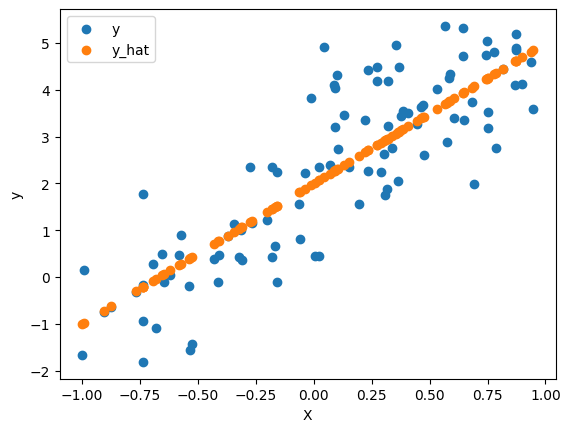

In [61]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

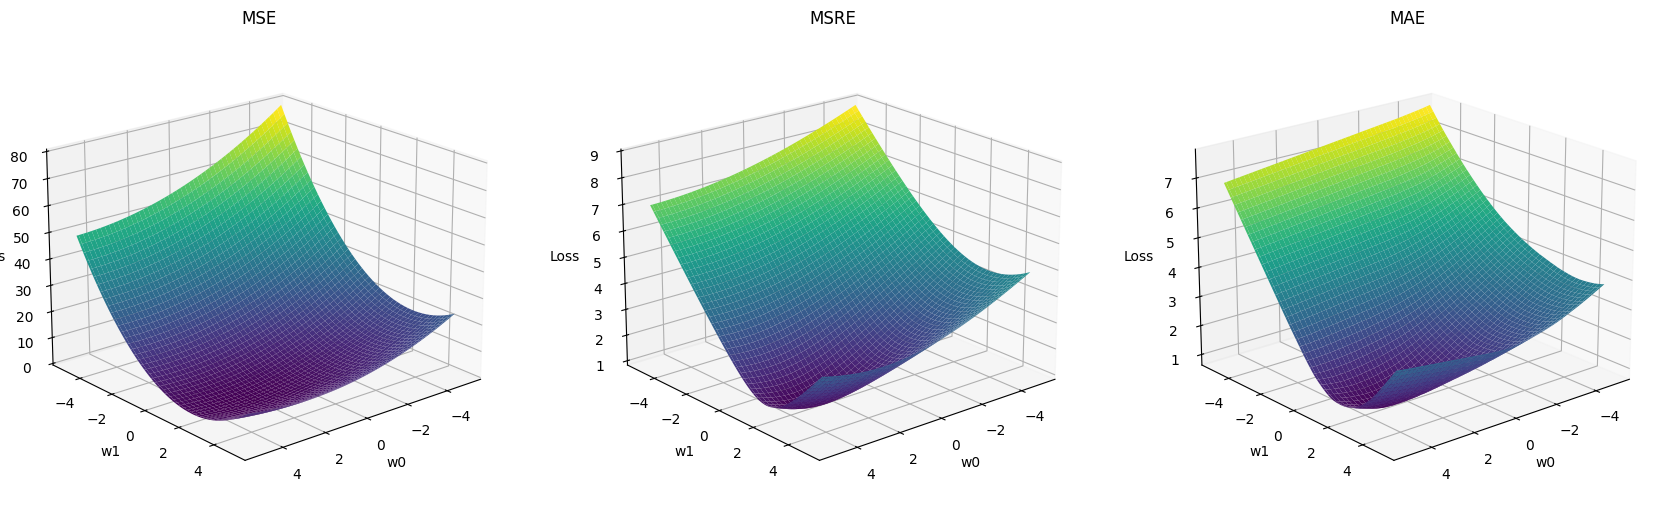

In [62]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [63]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [64]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [65]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in tqdm(optim_list):
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

#### SGD
$$\theta_t = \theta_{t-1} - \eta \sum_{i_1, ..., i_k} \nabla_{\theta} J_{i} (\theta_{t-1})$$

In [66]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad


#### Momentum
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [67]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= self.prev_momentum[i]

#### Nesterov Accelerated Gradient (NAG)
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1} - \gamma \nu_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [68]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= (1 + self.gamma) * self.prev_momentum[i] - self.gamma * prev_momentum

#### AdaGrad
$$G_t = \sum_{k=0}^t g_{k}^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [69]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta

        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G[i] += p.grad ** 2
                p -= self.eta * p.grad / torch.sqrt(self.G[i] + self.epsilon)

#### RMSProp
$$G_t = \gamma G_{t-1} + (1 - \gamma) g_t^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [70]:
class RMSProp(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, gamma=0.9):
        super().__init__(params)
        self.eta = eta
        self.epsilon = epsilon
        self.gamma = gamma

        self.G = [torch.zeros(p.shape) for p in self.params]


    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (p.grad ** 2)
                p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

In [71]:
from functools import partial

points, losses = optimize_function(
    partial(loss_animator.loss_func, loss=mse),
    SGD,
     {'lr': 1e-2},
    start_point=[-4, -4],
    num_iter=100
)

In [72]:
compare_optimizers(
    loss_animator,
    mae,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Momentum', NAG, {'lr': 1e-1}],
        ['NAG', NAG, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'eta' : 1}],
        ['RMSProp', RMSProp, {'eta' : 1}],
    ],
    start_point=[-4, -4],
    num_iter=100
)

  0%|          | 0/5 [00:00<?, ?it/s]

###  Домашнее задание: Обучение нейронной сети + Подбор шага

В этом задании вам нужно:
1) Реализовать Adam, AdamW и обучить сверточную нейросеть на MNIST. Сравнить графики обучения для SGD, Adam и AdamW. **(2 балла)**
2) Реализовать LinearLR и CosineAnnealingLR. Обучить сверточную нейросеть на MNIST с SGD, Adam, AdamW с LinearLR, CosineAnnealingLR. Сравните графики изменения loss-функции и точности (суммарно должно быть 9 экспериментов, 3 из которых покрываются пунктом 1). **(3 балла)**

Ссылки:
- https://arxiv.org/abs/1711.05101 (AdamW, статья)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.AdamW.html (AdamW, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html (LinearLR, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html (CosineAnnealingLR, PyTorch)

In [15]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

zsh:1: command not found: wget
tar: Error opening archive: Failed to open 'MNIST.tar.gz'


In [73]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [121]:
class LRScheduler:
    def __init__(self, optimizer: Optimizer, lr_attr: str = "lr"):
        self.optimizer = optimizer
        self.lr_attr = lr_attr
        
    def step(self):
        pass

In [122]:
class LinearLR(LRScheduler):
    def __init__(
        self,
        optimizer: Optimizer,
        start_factor: float = 0.1,
        end_factor: float = 1.0,
        total_iters: int = 100,
        lr_attr: str = "lr"
    ):
        super().__init__(optimizer, lr_attr)
        self.start_factor = start_factor
        self.end_factor = end_factor
        self.total_iters = total_iters
        self.last_epoch = 0

    def step(self):
        self.last_epoch += 1
        if self.last_epoch >= self.total_iters:
            factor = self.end_factor
        else:
            factor = self.start_factor + (self.end_factor - self.start_factor) * (self.last_epoch / self.total_iters)
        current_lr = getattr(self.optimizer, self.lr_attr)
        new_lr = current_lr * factor
        setattr(self.optimizer, self.lr_attr, new_lr)

class CosineAnnealingLR(LRScheduler):
    def __init__(
            self,
            optimizer: Optimizer,
            T_max: int = 20,
            eta_min: float = 0.01,
            lr_attr: str = "lr"
        ):
        super().__init__(optimizer, lr_attr)
        self.T_max = T_max
        self.eta_min = eta_min
        self.last_epoch = 0

    def step(self):
        self.last_epoch += 1
        if self.last_epoch > self.T_max:
            lr = self.eta_min
        else:
            current_lr = getattr(self.optimizer, self.lr_attr)
            lr = self.eta_min + (current_lr - self.eta_min) * \
                 (1 + np.cos(np.pi * self.last_epoch / self.T_max)) / 2
        setattr(self.optimizer, self.lr_attr, lr)

In [76]:
class Adam(Optimizer):
    def __init__(self, params, eta=1e-3, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params)
        self.eta = eta
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                grad = p.grad
                m = self.m[i]
                v = self.v[i]
                m.mul_(self.beta1).add_(grad, alpha=1 - self.beta1)
                v.mul_(self.beta2).addcmul_(grad, grad, value=1 - self.beta2)
                m_corr = m / (1 - self.beta1 ** self.t)
                v_corr = v / (1 - self.beta2 ** self.t)
                den = v_corr.sqrt().add_(self.eps)
                p -= self.eta / den * m_corr

In [88]:
class AdamW(Optimizer):
    def __init__(self, params, eta=1e-3, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=1e-2):
        super().__init__(params)
        self.eta = eta
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.weight_decay = weight_decay
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                grad = p.grad
                m = self.m[i]
                v = self.v[i]
                if self.weight_decay != 0:
                    p.mul_(1 - self.eta * self.weight_decay)
                m.mul_(self.beta1).add_(grad, alpha=1 - self.beta1)
                v.mul_(self.beta2).addcmul_(grad, grad, value=1 - self.beta2)
                m_corr = m / (1 - self.beta1 ** self.t)
                v_corr = v / (1 - self.beta2 ** self.t)
                den = v_corr.sqrt().add_(self.eps)
                p -= self.eta / den * m_corr

In [80]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [81]:
def train_epoch(model, optimizer, train_loader, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    return total_loss / len(train_loader), 100. * correct / total

def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return total_loss / len(test_loader), 100. * correct / total

In [98]:
epochs = 10
results = {}

In [99]:
model1 = CNN()
optimizer1 = SGD(model1.parameters())

In [100]:
train_losses, train_accs = [], []
test_losses, test_accs = [], []
for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model1, optimizer1, train_loader, criterion=nn.CrossEntropyLoss())
        test_loss, test_acc = evaluate(model1, test_loader, criterion=nn.CrossEntropyLoss())
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
results['SGD'] = {
    'train_losses': train_losses,
    'train_accuracies': train_accs,
    'test_losses': test_losses,
    'test_accuracies': test_accs
}

Epoch 1/10 | Train Loss: 0.3800, Train Acc: 88.99% | Test Loss: 0.1269, Test Acc: 96.35%
Epoch 2/10 | Train Loss: 0.1027, Train Acc: 96.90% | Test Loss: 0.0717, Test Acc: 97.68%
Epoch 3/10 | Train Loss: 0.0704, Train Acc: 97.88% | Test Loss: 0.0497, Test Acc: 98.36%
Epoch 4/10 | Train Loss: 0.0551, Train Acc: 98.34% | Test Loss: 0.0512, Test Acc: 98.33%
Epoch 5/10 | Train Loss: 0.0460, Train Acc: 98.59% | Test Loss: 0.0396, Test Acc: 98.71%
Epoch 6/10 | Train Loss: 0.0392, Train Acc: 98.79% | Test Loss: 0.0339, Test Acc: 98.77%
Epoch 7/10 | Train Loss: 0.0341, Train Acc: 98.94% | Test Loss: 0.0314, Test Acc: 98.84%
Epoch 8/10 | Train Loss: 0.0305, Train Acc: 99.06% | Test Loss: 0.0328, Test Acc: 98.94%
Epoch 9/10 | Train Loss: 0.0266, Train Acc: 99.19% | Test Loss: 0.0301, Test Acc: 98.93%
Epoch 10/10 | Train Loss: 0.0237, Train Acc: 99.27% | Test Loss: 0.0316, Test Acc: 98.91%


In [101]:
model2 = CNN()
optimizer2 = Adam(model2.parameters())

In [102]:
train_losses, train_accs = [], []
test_losses, test_accs = [], []
for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model2, optimizer2, train_loader, criterion=nn.CrossEntropyLoss())
        test_loss, test_acc = evaluate(model2, test_loader, criterion=nn.CrossEntropyLoss())
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
results['Adam'] = {
    'train_losses': train_losses,
    'train_accuracies': train_accs,
    'test_losses': test_losses,
    'test_accuracies': test_accs
}

Epoch 1/10 | Train Loss: 0.1174, Train Acc: 96.32% | Test Loss: 0.0409, Test Acc: 98.62%
Epoch 2/10 | Train Loss: 0.0396, Train Acc: 98.77% | Test Loss: 0.0316, Test Acc: 98.92%
Epoch 3/10 | Train Loss: 0.0263, Train Acc: 99.20% | Test Loss: 0.0268, Test Acc: 99.14%
Epoch 4/10 | Train Loss: 0.0191, Train Acc: 99.39% | Test Loss: 0.0373, Test Acc: 98.86%
Epoch 5/10 | Train Loss: 0.0148, Train Acc: 99.53% | Test Loss: 0.0500, Test Acc: 98.86%
Epoch 6/10 | Train Loss: 0.0132, Train Acc: 99.58% | Test Loss: 0.0304, Test Acc: 99.15%
Epoch 7/10 | Train Loss: 0.0080, Train Acc: 99.74% | Test Loss: 0.0340, Test Acc: 99.08%
Epoch 8/10 | Train Loss: 0.0088, Train Acc: 99.70% | Test Loss: 0.0350, Test Acc: 99.11%
Epoch 9/10 | Train Loss: 0.0077, Train Acc: 99.73% | Test Loss: 0.0411, Test Acc: 99.14%
Epoch 10/10 | Train Loss: 0.0044, Train Acc: 99.83% | Test Loss: 0.0415, Test Acc: 99.17%


In [103]:
model3 = CNN()
optimizer3 = AdamW(model3.parameters())

In [104]:
train_losses, train_accs = [], []
test_losses, test_accs = [], []
for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model3, optimizer3, train_loader, criterion=nn.CrossEntropyLoss())
        test_loss, test_acc = evaluate(model3, test_loader, criterion=nn.CrossEntropyLoss())
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
results['AdamW'] = {
    'train_losses': train_losses,
    'train_accuracies': train_accs,
    'test_losses': test_losses,
    'test_accuracies': test_accs
}

Epoch 1/10 | Train Loss: 0.1147, Train Acc: 96.44% | Test Loss: 0.0371, Test Acc: 98.75%
Epoch 2/10 | Train Loss: 0.0392, Train Acc: 98.81% | Test Loss: 0.0444, Test Acc: 98.57%
Epoch 3/10 | Train Loss: 0.0267, Train Acc: 99.15% | Test Loss: 0.0322, Test Acc: 98.93%
Epoch 4/10 | Train Loss: 0.0197, Train Acc: 99.39% | Test Loss: 0.0274, Test Acc: 99.07%
Epoch 5/10 | Train Loss: 0.0138, Train Acc: 99.55% | Test Loss: 0.0378, Test Acc: 98.81%
Epoch 6/10 | Train Loss: 0.0123, Train Acc: 99.60% | Test Loss: 0.0325, Test Acc: 98.99%
Epoch 7/10 | Train Loss: 0.0086, Train Acc: 99.70% | Test Loss: 0.0316, Test Acc: 99.09%
Epoch 8/10 | Train Loss: 0.0089, Train Acc: 99.70% | Test Loss: 0.0299, Test Acc: 99.03%
Epoch 9/10 | Train Loss: 0.0068, Train Acc: 99.79% | Test Loss: 0.0392, Test Acc: 99.08%
Epoch 10/10 | Train Loss: 0.0064, Train Acc: 99.80% | Test Loss: 0.0357, Test Acc: 99.19%


In [105]:
def plot_results(results, optimizers=['SGD', 'Adam', 'AdamW'], schedulers=['No Scheduler', 'LinearLR', 'CosineAnnealingLR']):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Comparison of Optimizers on MNIST', fontsize=16)
    for i, opt in enumerate(optimizers):
        if schedulers == None:
            key = f"{opt}"
            ax_loss = axes[0, i]
            ax_acc = axes[1, i]
            ax_loss.plot(results[key]['test_losses'], label=opt, marker='o', markersize=3, linewidth=1)
            ax_acc.plot(results[key]['test_accuracies'], label=opt, marker='s', markersize=3, linewidth=1)
        else: 
            for j, sched in enumerate(schedulers):
                key = f"{opt} + {sched}"
    
                ax_loss = axes[0, i]
                ax_acc = axes[1, i]
    
                ax_loss.plot(results[key]['test_losses'], label=sched, marker='o', markersize=3, linewidth=1)
                ax_acc.plot(results[key]['test_accuracies'], label=sched, marker='s', markersize=3, linewidth=1)
        ax_loss.set_title(f'{opt} - Test Loss')
        ax_acc.set_title(f'{opt} - Test Accuracy')
        ax_loss.legend()
        ax_acc.legend()
        ax_loss.grid(True, linestyle='--', alpha=0.6)
        ax_acc.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

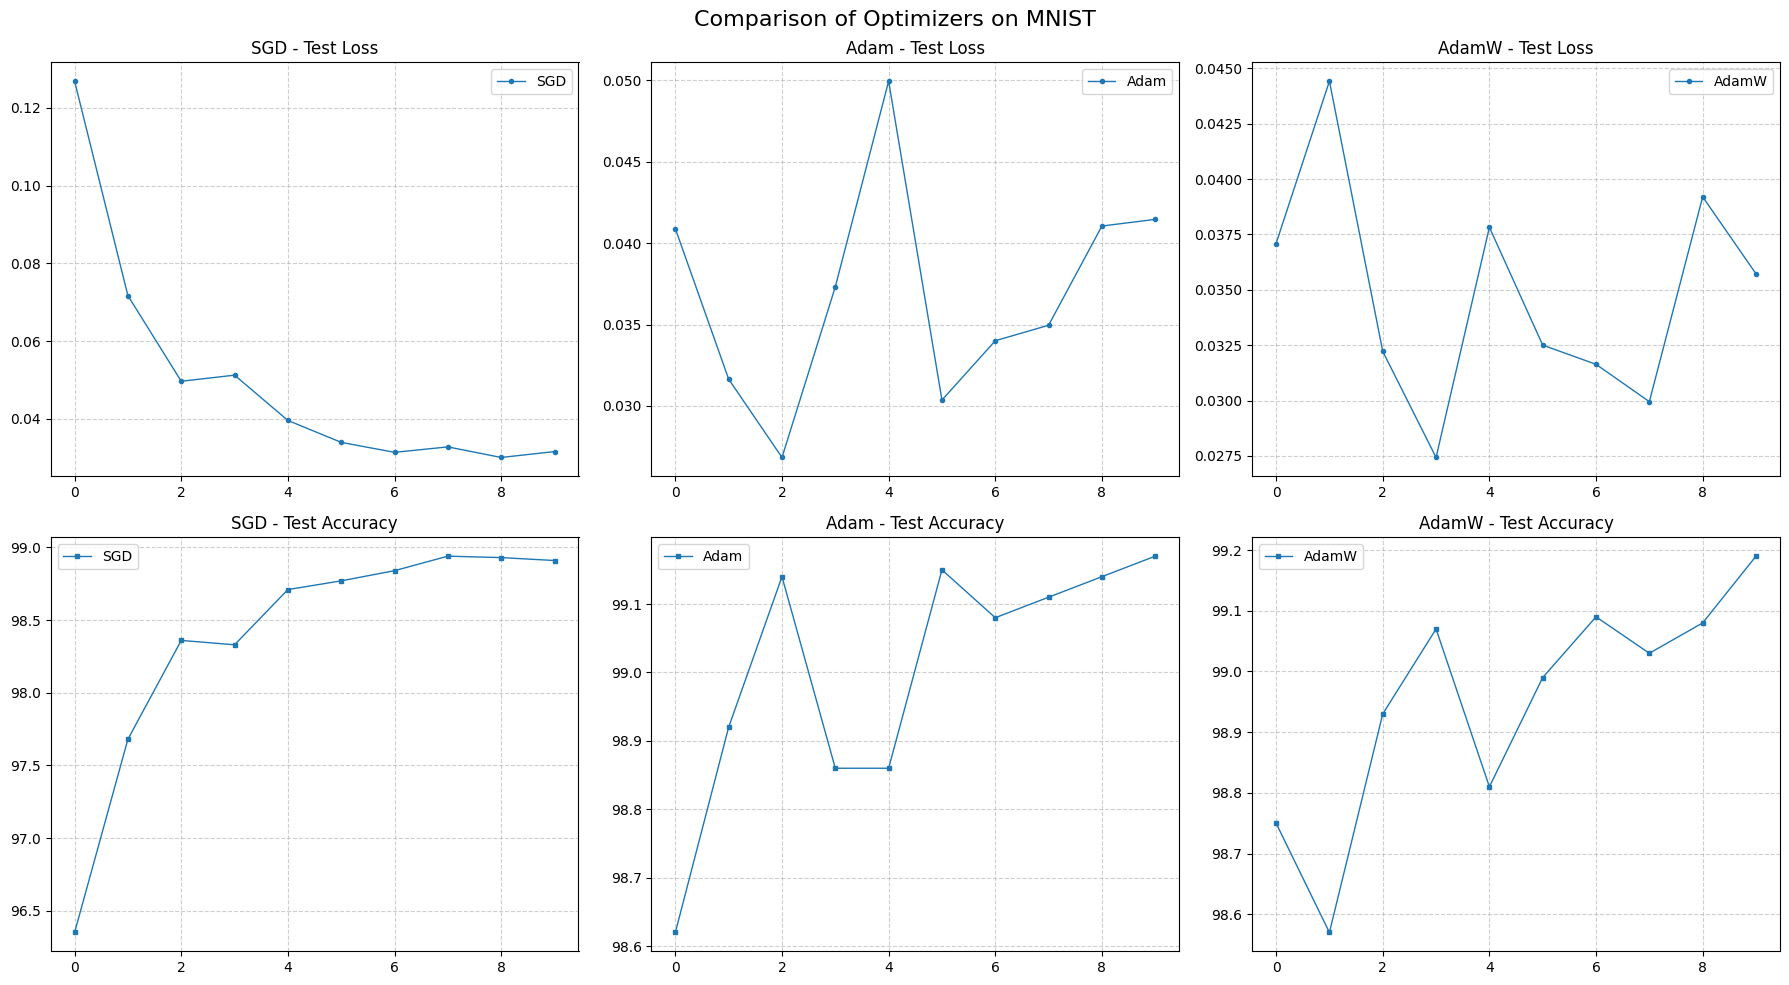

In [106]:
plot_results(results, schedulers=None)

In [123]:
OPTIMIZER_LR_ATTR = {
    SGD: "lr",
    Adam: "eta",
    AdamW: "eta",
}
schedulers_configs = [
    (LinearLR, {"start_factor": 0.1, "end_factor": 1.0, "total_iters": 5}),
    (CosineAnnealingLR, {"T_max": 10, "eta_min": 1e-5}),
]

optim_configs = [
    ("SGD", SGD, {"lr": 0.01}),
    ("Adam", Adam, {"eta": 0.001, "beta1": 0.9, "beta2": 0.999}),
    ("AdamW", AdamW, {"eta": 0.001, "beta1": 0.9, "beta2": 0.999, "weight_decay": 1e-2}),
]

for opt_name, opt_class, opt_kwargs in tqdm(optim_configs, desc="Optimizers"):
    for sched_class, sched_kwargs in schedulers_configs:
        exp_name = f"{opt_name} + {sched_class.__name__}"
        if exp_name in results:
            continue
        print(f"\n{'='*60}\nRunning: {exp_name}\n{'='*60}")
        model = CNN()
        optimizer = opt_class(model.parameters(), **opt_kwargs)
        lr_attr = OPTIMIZER_LR_ATTR[opt_class]
        sched_kwargs_with_attr = sched_kwargs.copy()
        sched_kwargs_with_attr["lr_attr"] = lr_attr
        scheduler = sched_class(optimizer, **sched_kwargs_with_attr)
        train_losses, train_accs = [], []
        test_losses, test_accs = [], []
        for epoch in range(epochs):
            train_loss, train_acc = train_epoch(model, optimizer, train_loader, criterion)
            test_loss, test_acc = evaluate(model, test_loader, criterion)
            scheduler.step()
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            test_losses.append(test_loss)
            test_accs.append(test_acc)
            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
                  f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

        results[exp_name] = {
            'train_losses': train_losses,
            'train_accuracies': train_accs,
            'test_losses': test_losses,
            'test_accuracies': test_accs
        }

Optimizers:   0%|          | 0/3 [00:00<?, ?it/s]


Running: SGD + LinearLR
Epoch 1/10 | Train Loss: 0.3619, Train Acc: 89.62% | Test Loss: 0.1116, Test Acc: 96.37%
Epoch 2/10 | Train Loss: 0.1001, Train Acc: 97.10% | Test Loss: 0.0865, Test Acc: 97.36%
Epoch 3/10 | Train Loss: 0.0849, Train Acc: 97.51% | Test Loss: 0.0749, Test Acc: 97.61%
Epoch 4/10 | Train Loss: 0.0790, Train Acc: 97.68% | Test Loss: 0.0708, Test Acc: 97.76%
Epoch 5/10 | Train Loss: 0.0757, Train Acc: 97.79% | Test Loss: 0.0678, Test Acc: 97.87%
Epoch 6/10 | Train Loss: 0.0731, Train Acc: 97.86% | Test Loss: 0.0664, Test Acc: 97.86%
Epoch 7/10 | Train Loss: 0.0709, Train Acc: 97.89% | Test Loss: 0.0648, Test Acc: 97.95%
Epoch 8/10 | Train Loss: 0.0686, Train Acc: 97.99% | Test Loss: 0.0620, Test Acc: 98.01%
Epoch 9/10 | Train Loss: 0.0667, Train Acc: 98.05% | Test Loss: 0.0604, Test Acc: 98.13%
Epoch 10/10 | Train Loss: 0.0648, Train Acc: 98.06% | Test Loss: 0.0590, Test Acc: 98.14%

Running: SGD + CosineAnnealingLR
Epoch 1/10 | Train Loss: 0.3992, Train Acc: 88.89%

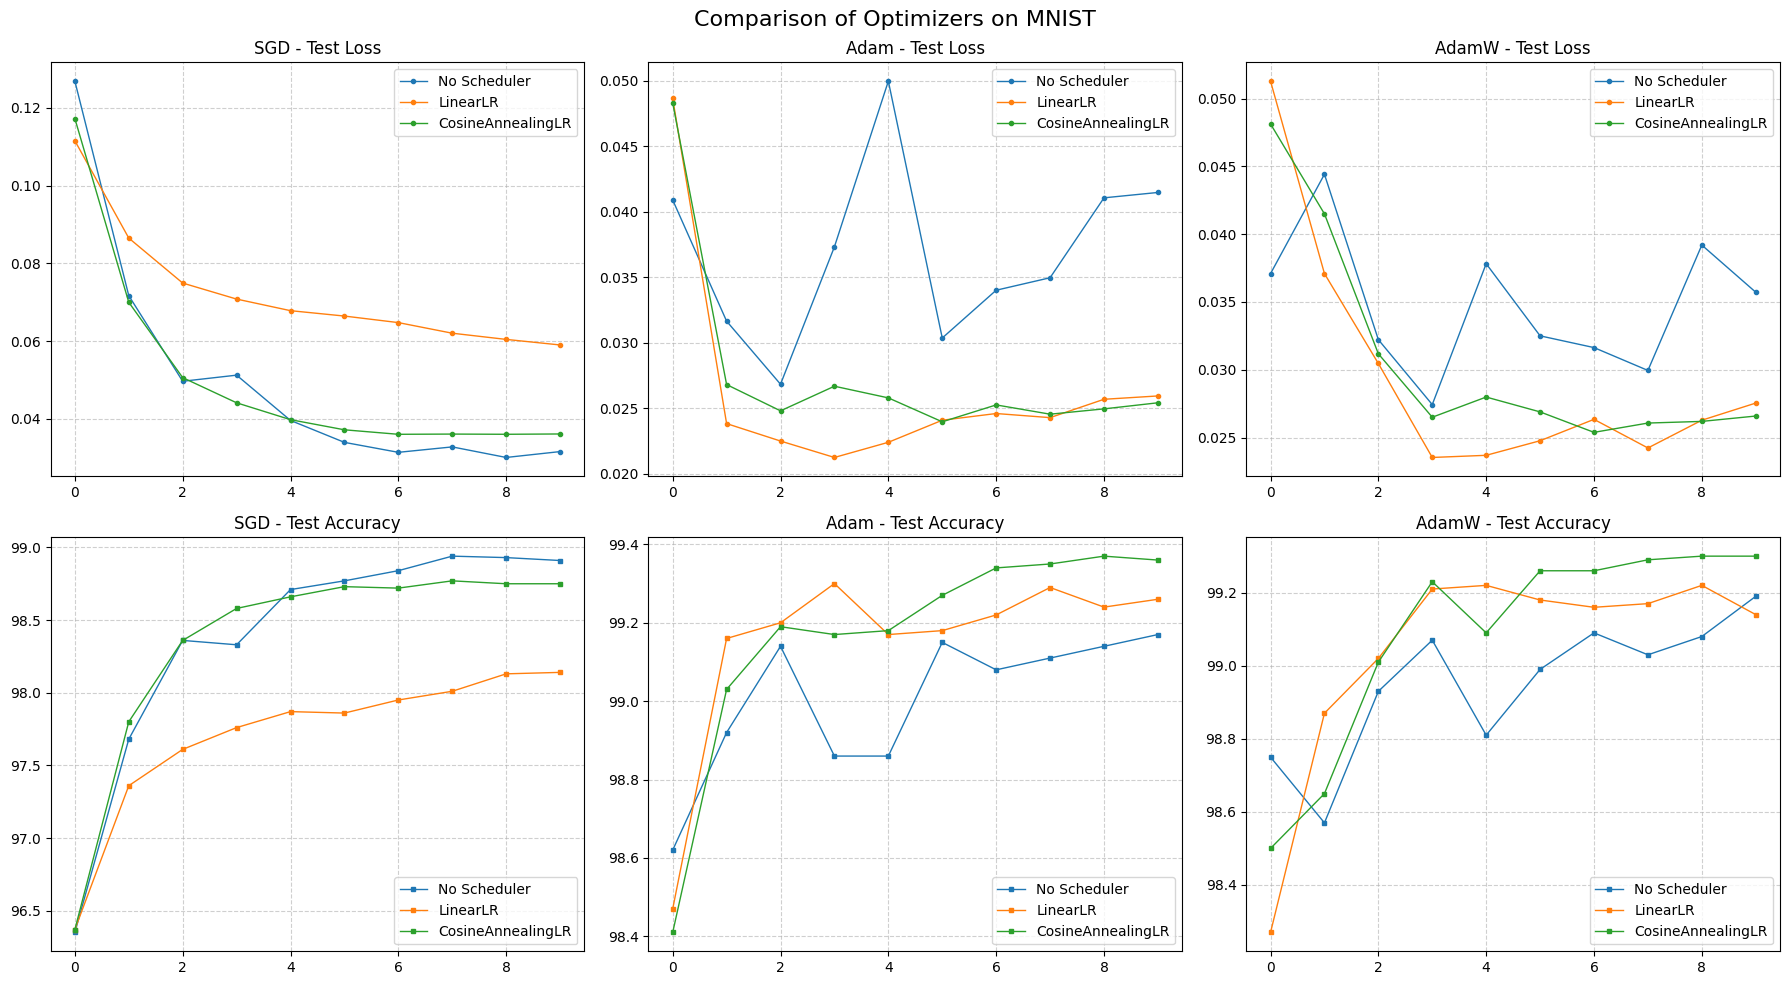

In [126]:
old_keys = ["SGD", "Adam", "AdamW"]
for old_key in old_keys:
    if old_key in results:
        new_key = f"{old_key} + No Scheduler"
        results[new_key] = results[old_key]
        del results[old_key]
plot_results(results)

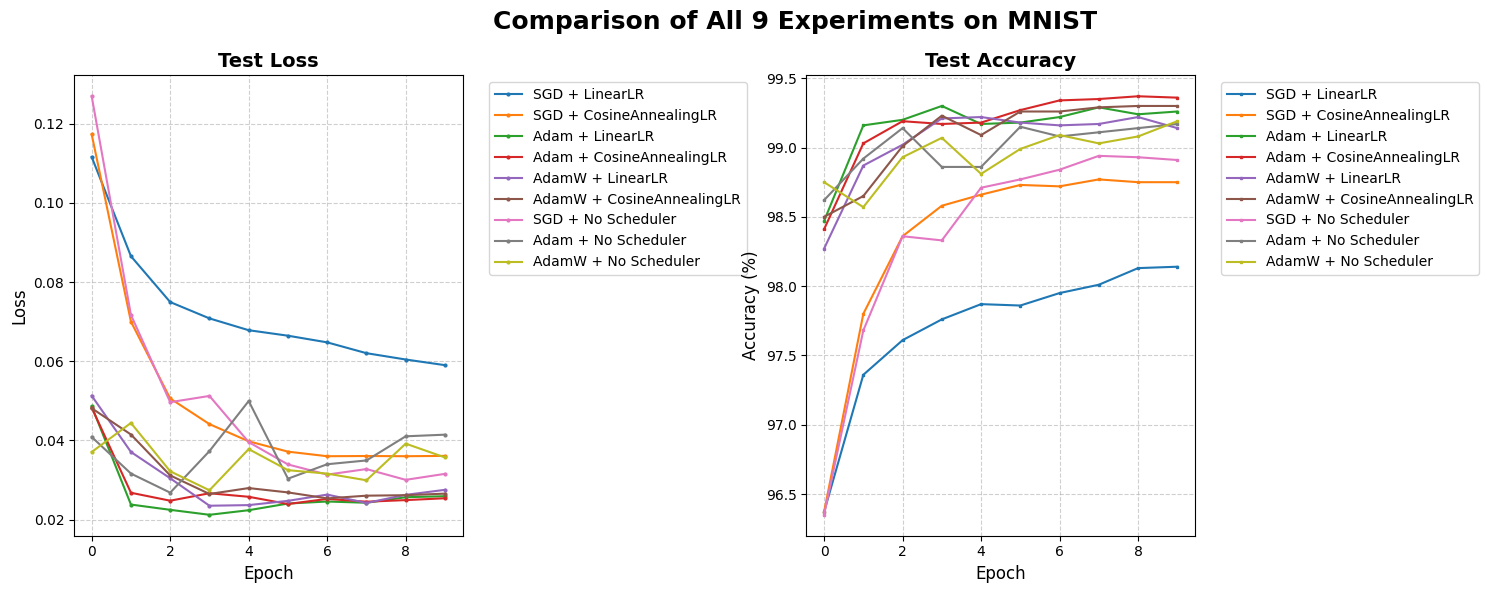

In [127]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Comparison of All 9 Experiments on MNIST', fontsize=18, fontweight='bold')

ax_loss = axes[0]
for exp_name in results:
    ax_loss.plot(results[exp_name]['test_losses'], label=exp_name, linewidth=1.5, marker='o', markersize=2)
ax_loss.set_title('Test Loss', fontsize=14, fontweight='bold')
ax_loss.set_xlabel('Epoch', fontsize=12)
ax_loss.set_ylabel('Loss', fontsize=12)
ax_loss.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, ncol=1)
ax_loss.grid(True, linestyle='--', alpha=0.6)

ax_acc = axes[1]
for exp_name in results:
    ax_acc.plot(results[exp_name]['test_accuracies'], label=exp_name, linewidth=1.5, marker='s', markersize=2)
ax_acc.set_title('Test Accuracy', fontsize=14, fontweight='bold')
ax_acc.set_xlabel('Epoch', fontsize=12)
ax_acc.set_ylabel('Accuracy (%)', fontsize=12)
ax_acc.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, ncol=1)
ax_acc.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.subplots_adjust(right=0.75) 
plt.show()

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

- Your text here

Здесь вы можете оставить комментарии по лекции или семинару:

- Your text here